# FEATURE ENGINEERING


## 0. Import Dependencies

In [169]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
#!pip install plotly
import plotly.express as px 
#!pip install missingno
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from IPython.display import display


In [132]:
SEED = 42
np.random.seed(SEED)

## 1. Set Up

### 1.1 File Paths

In [133]:
BASE_DIR = Path(r"C:/Users/black/Documents/Ironhack/final_project")
RAW_DIR = BASE_DIR / "data" / "raw"
CLEAN_DIR = BASE_DIR / "data" / "clean"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATENG_DIR = BASE_DIR / "data" / "feat_eng"

RAW_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FEATENG_DIR.mkdir(parents=True, exist_ok=True)

### 1.2 Plot Design


In [134]:
# seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# matplotlib general settings
plt.rcParams['figure.figsize'] = (5, 3)  # default figure size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.alpha'] = 0.3
# reproducibility
RANDOM_STATE = SEED
# custom color palette
colors = {
    'rosa': '#F4A3B8',     
    'pink': '#FF69B4',     
    'orange': '#FFA500',   
    'yellow': '#FFD700',   
    'red': '#FF4500',      
    'lilac': '#C8A2C8',    
}

sns.set_palette(list(colors.values()))
# display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data 

In [135]:
individual_df = pd.read_csv(r"data\feat_eng\individual_df.csv")
violence_df = pd.read_csv(r"data\feat_eng\violence_df.csv")
global_df = pd.read_csv(r"data\feat_eng\global_df.csv")

## 3. Individual Dataset


**Target Variable** : VIOLENCE (yes/no == 1/0)

*Which individual factors lead to experiencing violence as a woman?*

In [136]:
# chech unique values for encoding types, etc. 
individual_df.nunique()

age                39
education           4
employment          3
income             23
marital_status      2
violence_binary     2
vawg_rate           7
dtype: int64

In [137]:
# re-check if missing data 
individual_df.isna().sum()

age                0
education          0
employment         0
income             0
marital_status     0
violence_binary    0
vawg_rate          0
dtype: int64

In [138]:
# rename target column
individual_df = individual_df.rename(columns={"violence_binary" : "violence"})

**Feature Engineering Plan**

- encode:
    - education (ordinal, as natural order)
    - employment (one hot)
    - marital status (binary)

- normalize numeric features
    - age -> z-score
    - income -> log-transform (skewed!) + z-score

- interaction features
    - age × marital_status
    - education × employment
    - employment × marital_status
    - income × education

In [139]:
def feature_engineer_vawg(df_eng):
    """
    Feature engineering pipeline for VAWG (Violence Against Women) prediction.
    Focuses on high-priority features.
    """
     
    # Education: Ordinal encoding (inherent order)
    education_order = {
        'none': 0,
        'primary': 1,
        'secondary': 2,
        'higher': 3,
        'tertiary': 3  
    }
    df_eng['education_ordinal'] = df_eng['education'].str.lower().map(education_order)
    
    # Employment: One-hot encoding (only 3 categories)
    df_eng = pd.get_dummies(df_eng, columns=['employment'], prefix='emp', drop_first=False)
    
    # Handle potential column name variations
    if 'emp_unemployed' not in df_eng.columns:
        # Create from available columns
        emp_cols = [col for col in df_eng.columns if col.startswith('emp_')]
        if emp_cols:
            df_eng['emp_unemployed'] = (~df_eng[emp_cols].any(axis=1)).astype(int)
    
    # Marital status: Binary encoding
    df_eng['is_married'] = df_eng['marital_status'].str.lower().isin(['married', 'living_together']).astype(int)
    
    # Income: Log transformation (handles skewness)
    df_eng['income_log'] = np.log1p(df_eng['income'])
    
    # Standardization
    scaler = StandardScaler()
    df_eng['age_scaled'] = scaler.fit_transform(df_eng[['age']])
    df_eng['income_scaled'] = scaler.fit_transform(df_eng[['income_log']])
    
    # Vulnerability markers for VAWG
    df_eng['young_unmarried'] = ((df_eng['age'] < 25) & (df_eng['is_married'] == 0)).astype(int)
    
    df_eng['low_education_unemployed'] = (
        (df_eng['education_ordinal'] <= 1) & 
        (df_eng['emp_unemployed'] == 1)
    ).astype(int)
    
    df_eng['married_unemployed'] = (df_eng['is_married'] * df_eng['emp_unemployed']).astype(int)
    
    # Economic vulnerability
    df_eng['age_income'] = df_eng['age_scaled'] * df_eng['income_scaled']
    df_eng['education_income'] = df_eng['education_ordinal'] * df_eng['income_scaled']
     
    # Age groups (non-linear risk patterns)
    df_eng['age_group_young'] = (df_eng['age'] < 25).astype(int)
    df_eng['age_group_middle'] = ((df_eng['age'] >= 25) & (df_eng['age'] < 35)).astype(int)
    # Reference group: 35+ (implicit)
    
    # Economic vulnerability index (0-3 score)
    df_eng['economic_vulnerability'] = (
        (df_eng['income'] < df_eng['income'].quantile(0.25)).astype(int) +
        (df_eng['emp_unemployed'] == 1).astype(int) +
        (df_eng['education_ordinal'] <= 1).astype(int)
    )
    
    # Empowerment proxy (education + employment)
    df_eng['empowerment_score'] = df_eng['education_ordinal'] + (1 - df_eng['emp_unemployed'])
    
    # High VAWG environment indicator
    df_eng['high_vawg_environment'] = (df_eng['vawg_rate'] > df_eng['vawg_rate'].median()).astype(int)
    
    # Define feature columns (exclude original raw columns and target)
    feature_cols = [
        # Encoded categorical
        'education_ordinal',
        'is_married',
        'emp_unemployed',
        
        # Scaled numeric
        'age_scaled',
        'income_scaled',
        'vawg_rate',
        
        # High-priority interactions
        'young_unmarried',
        'low_education_unemployed',
        'married_unemployed',
        'age_income',
        'education_income',
        
        # Composite features
        'age_group_young',
        'age_group_middle',
        'economic_vulnerability',
        'empowerment_score',
        'high_vawg_environment'
    ]
    
    # Add any additional employment dummies that exist
    other_emp_cols = [col for col in df_eng.columns 
                      if col.startswith('emp_') and col != 'emp_unemployed']
    feature_cols.extend(other_emp_cols)
    
    # Keep only relevant columns
    target_col = 'violence' if 'violence' in df_eng.columns else None
    
    if target_col:
        final_cols = feature_cols + [target_col]
    else:
        final_cols = feature_cols
    
    # Filter to only existing columns
    final_cols = [col for col in final_cols if col in df_eng.columns]
    
    df_final = df_eng[final_cols].copy()
    
    return df_final

def get_feature_descriptions():
    """
    Returns a dictionary describing all engineered features.
    """
    descriptions = {
        'education_ordinal': 'Education level (0=none, 1=primary, 2=secondary, 3=higher)',
        'is_married': 'Binary indicator for married/living together (1) vs unmarried (0)',
        'emp_unemployed': 'Binary indicator for unemployment status',
        'age_scaled': 'Standardized age (z-score)',
        'income_scaled': 'Standardized log-transformed income',
        'vawg_rate': 'Violence against women rate in demographic group',
        'young_unmarried': 'Young (<25) AND unmarried women (higher vulnerability)',
        'low_education_unemployed': 'Low education (≤primary) AND unemployed (economic dependency)',
        'married_unemployed': 'Married AND unemployed (potential economic control)',
        'age_income': 'Interaction between age and income (life-stage economic status)',
        'education_income': 'Interaction between education and income (achievement vs means)',
        'age_group_young': 'Age < 25 years',
        'age_group_middle': 'Age 25-34 years',
        'economic_vulnerability': 'Composite score (0-3): low income + unemployed + low education',
        'empowerment_score': 'Composite: education level + employment status',
        'high_vawg_environment': 'Living in high VAWG-rate demographic group'
    }
    return descriptions

In [140]:
# Apply the pipeline
ind_df_final = feature_engineer_vawg(individual_df)

# View the engineered features
print(ind_df_final.head())
print(f"\nShape: {ind_df_final.shape}")
print(f"Features: {ind_df_final.columns.tolist()}")

# Get feature descriptions
descriptions = get_feature_descriptions()

   education_ordinal  is_married  emp_unemployed  age_scaled  income_scaled  vawg_rate  young_unmarried  \
0                  2           1            True       -0.13          -0.44      18.59                0   
1                  3           1            True        1.64          -0.44      19.82                0   
2                  3           0            True       -0.75          -0.44      19.82                1   
3                  3           0            True       -0.96          -0.44      19.82                1   
4                  1           1            True        1.95          -0.44      21.49                0   

   low_education_unemployed  married_unemployed  age_income  education_income  age_group_young  age_group_middle  \
0                         0                   1        0.06             -0.87                0                 1   
1                         0                   1       -0.71             -1.31                0                 0   
2        

In [141]:
# check for correct data type
print(ind_df_final.columns.tolist())
print(ind_df_final.dtypes.tolist())


['education_ordinal', 'is_married', 'emp_unemployed', 'age_scaled', 'income_scaled', 'vawg_rate', 'young_unmarried', 'low_education_unemployed', 'married_unemployed', 'age_income', 'education_income', 'age_group_young', 'age_group_middle', 'economic_vulnerability', 'empowerment_score', 'high_vawg_environment', 'emp_employed', 'emp_semi employed', 'violence']
[dtype('int64'), dtype('int64'), dtype('bool'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('bool'), dtype('bool'), dtype('int64')]


In [142]:
ind_df_final.to_csv(FEATENG_DIR / "ind_df_final.csv", index=False)

## 4. Violence Dataset 

**Target Variable**:    IPV (intimate partner violence)

**Question**:           *What country-level factors predict intimate partner violence?*

In [143]:
violence_df.head()

,npv,ipv,atv,ld,ih,wdi,gii,sec_edu_gap,lab_force_gap,wpsi,country
0,26.00,30.00,52.00,87.00,13.00,450.66,0.05,3.60,41.50,0.87,United Arab Emirates
1,34.00,73.00,7.00,26.00,19.00,494.11,0.29,0.40,21.60,0.77,Argentina
2,95.00,38.00,7.00,17.00,7.00,370.10,0.07,-0.20,9.40,0.90,Australia
3,23.00,29.00,20.00,28.00,8.00,251.63,0.05,0.00,10.80,0.91,Austria
4,46.00,53.00,20.00,26.00,16.00,372.88,0.05,2.50,9.00,0.90,Belgium


In [144]:
# check unique variables for pot encoding -> no encoding needed 
violence_df.nunique()

npv              22
ipv              33
atv              28
ld               24
ih               22
wdi              50
gii              47
sec_edu_gap      44
lab_force_gap    48
wpsi             45
country          50
dtype: int64

In [145]:
feature_descriptions = {
    "npv" : "non-partner violence",
    "ipv" : "intimate-partner violence",
    "atv" : "attitude towards violence",
    "ld" : "legal discrimination",
    "ih" :"intentional homicide",
    "wdi" : "women danger index",
    "gii" : "gender inequality index",
    "sec_edu_gap" : "secondary education gap f/m",
    "lab_force_gap" : "labour force gap f/m",
    "country" : "country"
}

In [146]:
# re-check missing values 
violence_df.isna().sum()

npv              0
ipv              0
atv              0
ld               0
ih               0
wdi              0
gii              0
sec_edu_gap      0
lab_force_gap    0
wpsi             0
country          0
dtype: int64

**Feature Engineering Plan**

- Composite Indices (PCA-based):
    - structural_inequality_index: GII + WPSI + gaps + legal discrimination
    - violence_exposure_index: IPV + NPV + ATV combined
    - general_danger_index: WDI + intentional homicide + legal discrimination

- Domain-Specific Composites:
    - economic_empowerment_gap: Education + labor force gaps
    - inequality_attitudes_interaction: Structural inequality × attitudes (reinforcement)
    - education_attitudes_interaction: Education gap × attitudes (knowledge-belief disconnect)
    - legal_violence_interaction: Legal discrimination × violence (impunity effect)

In [147]:
def correlations(df):
    """
    Correlations to understand feature relationships
    """
    # Exclude country column
    numeric_cols = [col for col in df.columns if col != 'country']
    
    # Correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=1)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify high correlations (>0.7)
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    print("HIGH CORRELATIONS (|r| > 0.7):")
    for item in high_corr:
        print(f"{item['feature1']} ↔ {item['feature2']}: {item['correlation']:.3f}")
    
    return corr_matrix

In [148]:
def create_composite_indices(df):
    """
    Create composite indices using PCA and domain knowledge
    """
    df_eng = df
    
    # Standardize all numeric features first
    numeric_cols = [col for col in df.columns if col != 'country']
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )
    
    # STRUCTURAL INEQUALITY INDEX
    # Combines: GII, WPSI, education gap, labor force gap, legal discrimination
    structural_features = ['gii', 'wpsi', 'sec_edu_gap', 'lab_force_gap', 'ld']
    
    pca_structural = PCA(n_components=1)
    df_eng['structural_inequality_index'] = pca_structural.fit_transform(
        df_scaled[structural_features]
    )
    
    print(f"Variance explained: {pca_structural.explained_variance_ratio_[0]:.3f}")
    for feat, loading in zip(structural_features, pca_structural.components_[0]):
        print(f"  {feat}: {loading:.3f}")
    
    # VIOLENCE EXPOSURE INDEX
    # Combines: IPV, NPV, ATV
    violence_features = ['ipv', 'npv', 'atv']
    
    pca_violence = PCA(n_components=1)
    df_eng['violence_exposure_index'] = pca_violence.fit_transform(
        df_scaled[violence_features]
    )
    
    print(f"Variance explained: {pca_violence.explained_variance_ratio_[0]:.3f}")
    for feat, loading in zip(violence_features, pca_violence.components_[0]):
        print(f"  {feat}: {loading:.3f}")
    
    # GENERAL DANGER INDEX
    # Simple weighted average (interpretable alternative to PCA)
    df_eng['general_danger_index'] = (
        df_scaled['wdi'] + 
        df_scaled['ih'] + 
        df_scaled['ld']
    ) / 3
    
    # ECONOMIC EMPOWERMENT GAP
    df_eng['economic_empowerment_gap'] = (
        df_scaled['sec_edu_gap'] + 
        df_scaled['lab_force_gap']
    ) / 2
    
    # INTERACTION FEATURES
    # Structural inequality × Attitudes (reinforcement effect)
    df_eng['inequality_attitudes_interaction'] = (
        df_eng['structural_inequality_index'] * df_scaled['atv']
    )
    
    # Education gap × Attitudes (knowledge-belief disconnect)
    df_eng['education_attitudes_interaction'] = (
        df_scaled['sec_edu_gap'] * df_scaled['atv']
    )
    
    # Legal discrimination × Violence (impunity effect)
    df_eng['legal_violence_interaction'] = (
        df_scaled['ld'] * df_eng['violence_exposure_index']
    )
    
    return df_eng, scaler


In [149]:
def feature_importance_analysis(df, target_var='ipv'):
    """
    Analyze feature importance for a given target
    """
    # Separate features and target
    X = df.drop(columns=['country', target_var])
    y = df[target_var]
    
    # Calculate mutual information (works for both linear and non-linear relationships)
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    
    print("\n" + "="*60)
    print(f"FEATURE IMPORTANCE FOR PREDICTING: {target_var.upper()}")
    print("="*60)
    print("\nMutual Information Scores:")
    for feat, score in mi_scores.items():
        print(f"  {feat}: {score:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='barh')
    plt.xlabel('Mutual Information Score')
    plt.title(f'Feature Importance for Predicting {target_var.upper()}', 
              fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return mi_scores

In [150]:
def prepare_for_modeling(df, target_var='ipv', use_composite_only=False):
    """
    Prepare final dataset for modeling
    """
    df_model = df.copy()
    
    if use_composite_only:
        # Use only composite indices (reduced dimensionality)
        feature_cols = [
            'structural_inequality_index',
            'violence_exposure_index',
            'general_danger_index',
            'economic_empowerment_gap',
            'inequality_attitudes_interaction',
            'education_attitudes_interaction',
            'legal_violence_interaction'
        ]
    else:
        # Use all features, but remove redundant/highly correlated ones
        # Remove WPSI (keep GII as it's more standard)
        # Keep individual violence measures for nuance
        feature_cols = [
            'gii', 'sec_edu_gap', 'lab_force_gap', 'ld', 'ih', 'wdi',
            'ipv', 'npv', 'atv',
            # Plus composite indices
            'structural_inequality_index',
            'general_danger_index',
            'economic_empowerment_gap',
            'inequality_attitudes_interaction',
            'education_attitudes_interaction',
            'legal_violence_interaction'
        ]
        
        # Remove target from features
        if target_var in feature_cols:
            feature_cols.remove(target_var)
    
    X = df_model[feature_cols]
    y = df_model[target_var]
    
    print(f"Target variable: {target_var}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Features: {feature_cols}")
    print(f"\nDataset shape: {X.shape}")
    print(f"Target distribution:\n{y.describe()}")
    
    return X, y


In [194]:
def full_pipeline(df, target_var='ipv', use_composite_only=False):
    """
    Complete feature engineering pipeline
    """
    # Explore correlations
    corr_matrix = correlations(df)
    
    # Create composite indices
    df_eng, scaler = create_composite_indices(df)
    
    # Feature importance analysis
    mi_scores = feature_importance_analysis(df_eng, target_var=target_var)
    
    # Prepare for modeling
    X, y = prepare_for_modeling(df_eng, target_var=target_var, 
                                 use_composite_only=use_composite_only)
    
    return X, y, df_eng

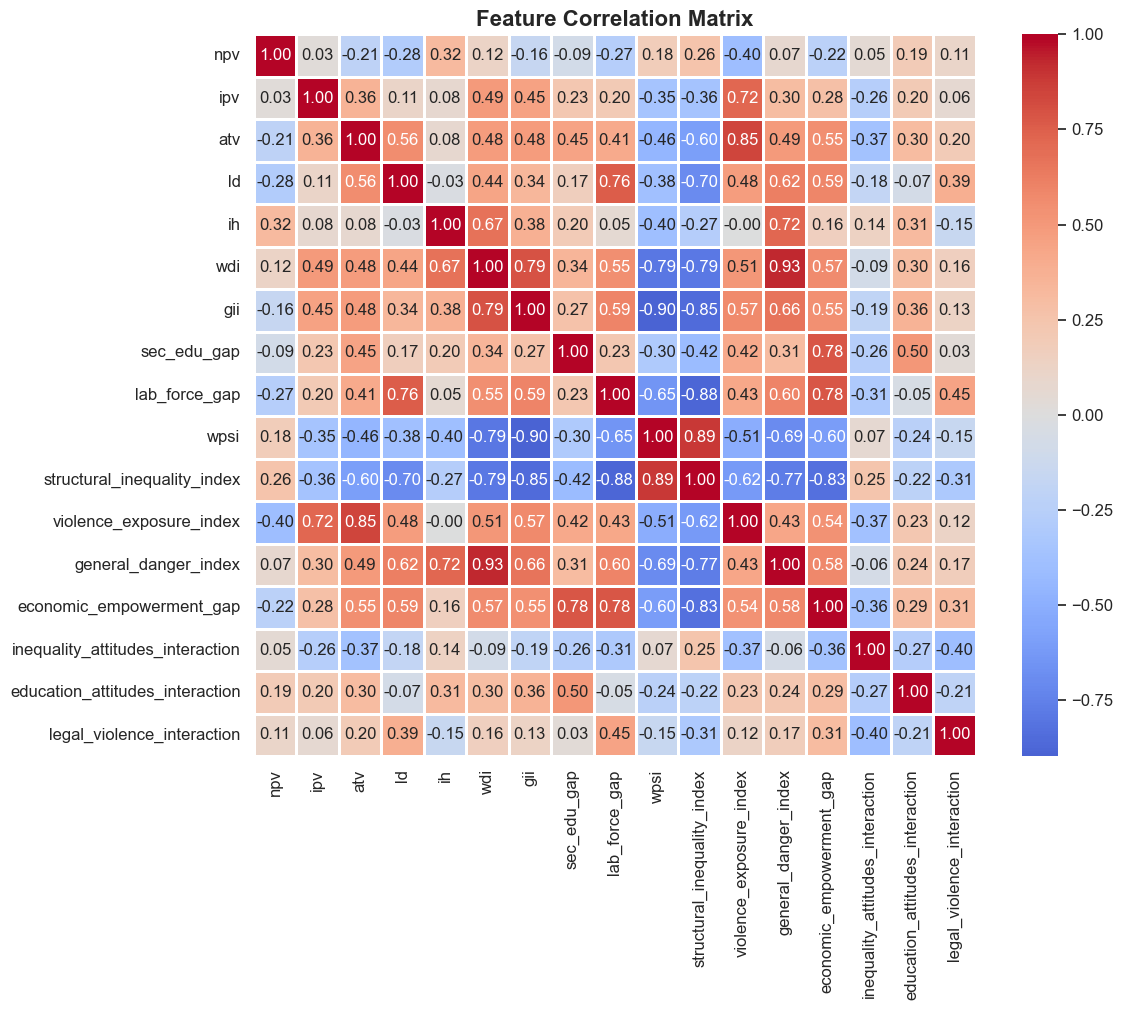

HIGH CORRELATIONS (|r| > 0.7):
ipv ↔ violence_exposure_index: 0.722
atv ↔ violence_exposure_index: 0.849
ld ↔ lab_force_gap: 0.758
ih ↔ general_danger_index: 0.724
wdi ↔ gii: 0.794
wdi ↔ wpsi: -0.793
wdi ↔ structural_inequality_index: -0.786
wdi ↔ general_danger_index: 0.929
gii ↔ wpsi: -0.896
gii ↔ structural_inequality_index: -0.854
sec_edu_gap ↔ economic_empowerment_gap: 0.785
lab_force_gap ↔ structural_inequality_index: -0.877
lab_force_gap ↔ economic_empowerment_gap: 0.785
wpsi ↔ structural_inequality_index: 0.885
structural_inequality_index ↔ general_danger_index: -0.770
structural_inequality_index ↔ economic_empowerment_gap: -0.825
Variance explained: 0.589
  gii: -0.498
  wpsi: 0.516
  sec_edu_gap: -0.244
  lab_force_gap: -0.511
  ld: -0.407
Variance explained: 0.469
  ipv: 0.609
  npv: -0.341
  atv: 0.716

FEATURE IMPORTANCE FOR PREDICTING: IPV

Mutual Information Scores:
  violence_exposure_index: 0.2745
  wdi: 0.2276
  general_danger_index: 0.1852
  structural_inequality_ind

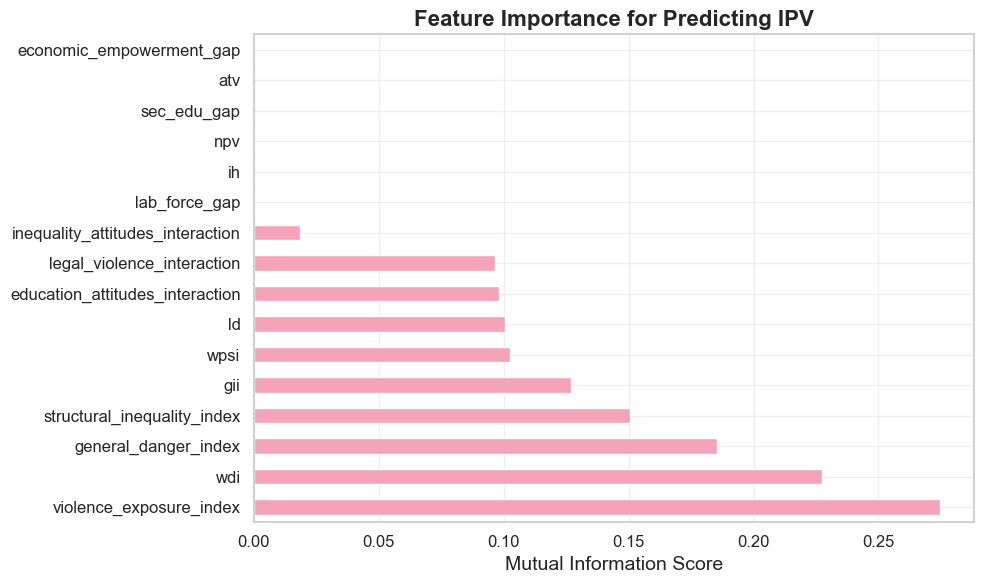

Target variable: ipv
Number of features: 14
Features: ['gii', 'sec_edu_gap', 'lab_force_gap', 'ld', 'ih', 'wdi', 'npv', 'atv', 'structural_inequality_index', 'general_danger_index', 'economic_empowerment_gap', 'inequality_attitudes_interaction', 'education_attitudes_interaction', 'legal_violence_interaction']

Dataset shape: (50, 14)
Target distribution:
count    50.00
mean     51.84
std      21.39
min      14.00
25%      32.25
50%      48.00
75%      65.50
max     100.00
Name: ipv, dtype: float64


In [195]:
# all features
violence_df_all = full_pipeline(violence_df, use_composite_only=False)

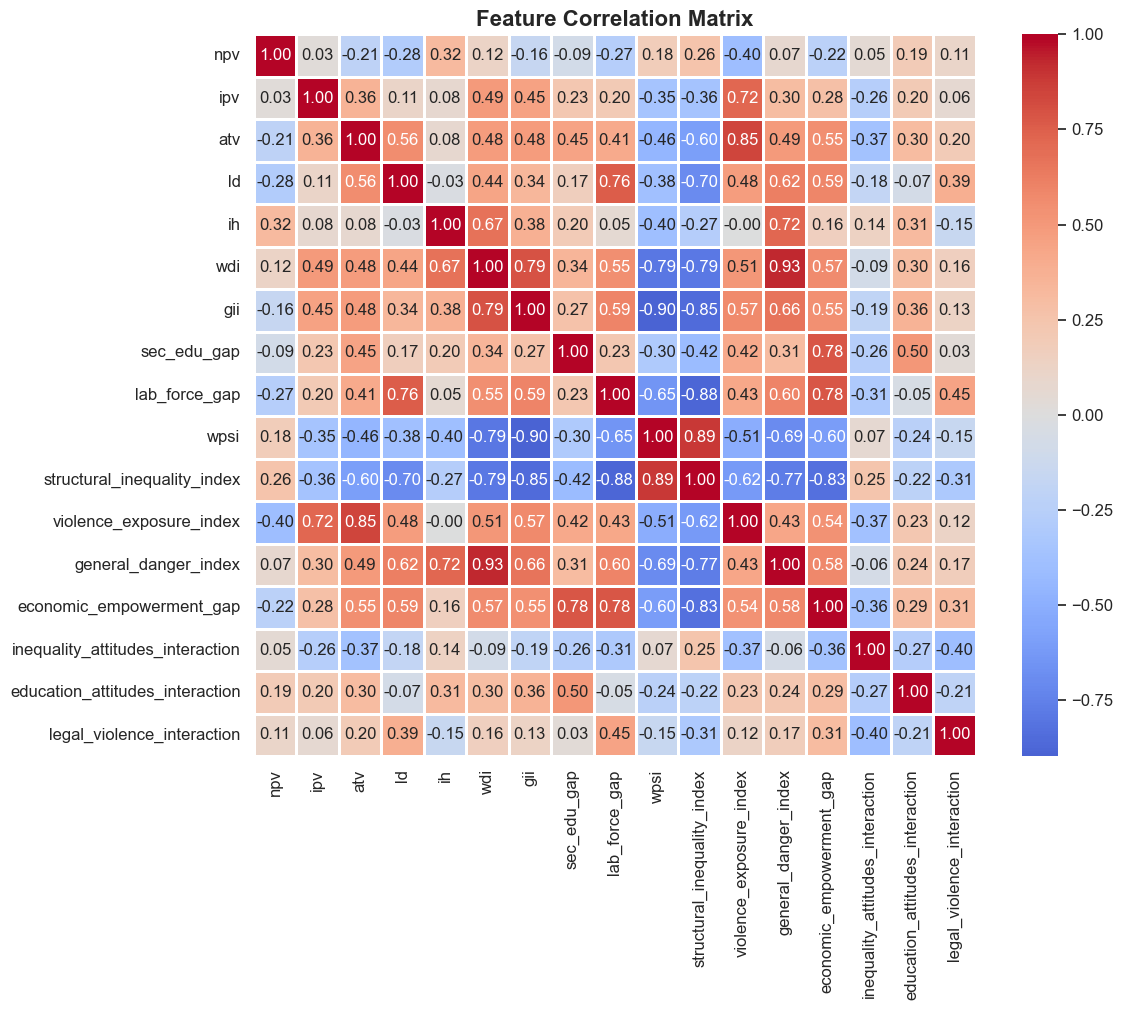

HIGH CORRELATIONS (|r| > 0.7):
ipv ↔ violence_exposure_index: 0.722
atv ↔ violence_exposure_index: 0.849
ld ↔ lab_force_gap: 0.758
ih ↔ general_danger_index: 0.724
wdi ↔ gii: 0.794
wdi ↔ wpsi: -0.793
wdi ↔ structural_inequality_index: -0.786
wdi ↔ general_danger_index: 0.929
gii ↔ wpsi: -0.896
gii ↔ structural_inequality_index: -0.854
sec_edu_gap ↔ economic_empowerment_gap: 0.785
lab_force_gap ↔ structural_inequality_index: -0.877
lab_force_gap ↔ economic_empowerment_gap: 0.785
wpsi ↔ structural_inequality_index: 0.885
structural_inequality_index ↔ general_danger_index: -0.770
structural_inequality_index ↔ economic_empowerment_gap: -0.825
Variance explained: 0.589
  gii: -0.498
  wpsi: 0.516
  sec_edu_gap: -0.244
  lab_force_gap: -0.511
  ld: -0.407
Variance explained: 0.469
  ipv: 0.609
  npv: -0.341
  atv: 0.716

FEATURE IMPORTANCE FOR PREDICTING: IPV

Mutual Information Scores:
  violence_exposure_index: 0.2745
  wdi: 0.2276
  general_danger_index: 0.1852
  structural_inequality_ind

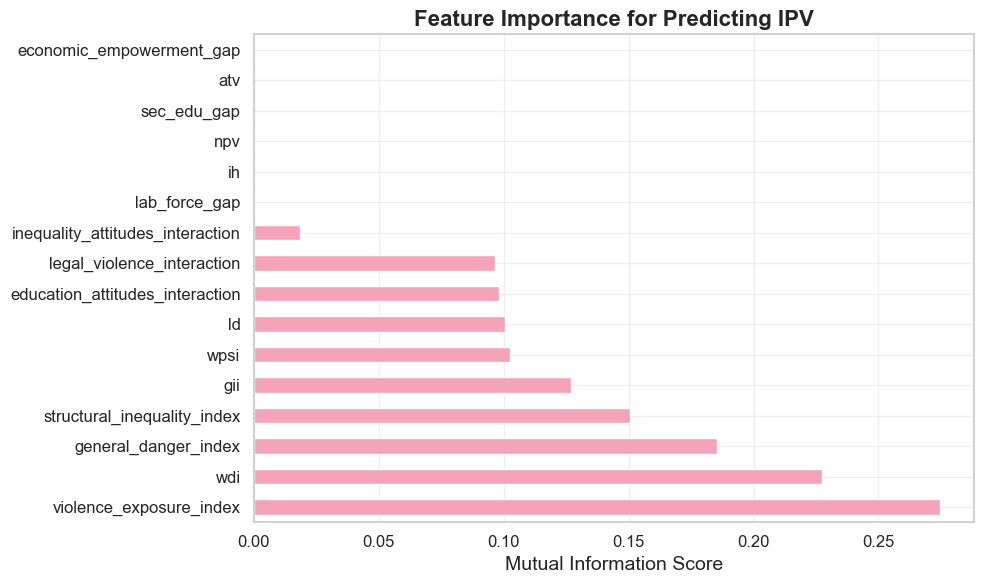

Target variable: ipv
Number of features: 7
Features: ['structural_inequality_index', 'violence_exposure_index', 'general_danger_index', 'economic_empowerment_gap', 'inequality_attitudes_interaction', 'education_attitudes_interaction', 'legal_violence_interaction']

Dataset shape: (50, 7)
Target distribution:
count    50.00
mean     51.84
std      21.39
min      14.00
25%      32.25
50%      48.00
75%      65.50
max     100.00
Name: ipv, dtype: float64


In [196]:
# composite features only
violence_df_fe = full_pipeline(violence_df, use_composite_only=True)

In [199]:
violence_df_final_all = violence_df_all[0]
violence_df_final_fe = violence_df_fe[0]

In [200]:
violence_df_final_all.to_csv(FEATENG_DIR / "violence_df_final_all", index=False)
violence_df_final_fe.to_csv(FEATENG_DIR / "violence_df_final_fe", index=False)

## 5. Global Dataset

In [155]:
global_df.head()

,country,income_category,log_GNI,pf_score,ef_score,gug_15-24,gug_25+,gug_under15,gii,maternal_mortality,adolescent_birth_rate,seats_parliament,human_development_encoded,sec_edu_gap,lab_force_gap,percent_leg_equ_achiev_marriage,ip_violence,wpsi
0,Afghanistan,Low Income,0.26,NaN,NaN,13.56,15.21,15.66,0.68,638.00,82.60,27.20,1.00,8.50,51.70,NaN,46.00,0.29
1,Angola,Upper-Middle Income,0.74,6.02,5.91,-3.89,1.59,0.21,0.54,241.00,138.40,29.50,2.00,23.30,5.10,NaN,38.00,0.60
2,Albania,High Income,1.15,7.69,7.64,-2.06,0.16,-0.27,0.14,15.00,14.50,35.70,3.00,-2.40,15.50,NaN,13.00,0.80
3,Andorra,High Income,1.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.90,46.40,4.00,1.70,NaN,NaN,NaN,NaN
4,United Arab Emirates,High Income,1.80,4.63,7.35,11.79,3.76,4.58,0.05,3.00,3.10,50.00,4.00,3.60,41.50,63.64,NaN,0.87


In [156]:
global_df.nunique()

country                            195
income_category                      4
log_GNI                            195
pf_score                           147
ef_score                           131
gug_15-24                          178
gug_25+                            186
gug_under15                        186
gii                                151
maternal_mortality                 115
adolescent_birth_rate              176
seats_parliament                   157
human_development_encoded            4
sec_edu_gap                        142
lab_force_gap                      152
percent_leg_equ_achiev_marriage     11
ip_violence                         41
wpsi                               147
dtype: int64

In [157]:
global_df.isna().sum()

country                             9
income_category                     9
log_GNI                             9
pf_score                           39
ef_score                           39
gug_15-24                          17
gug_25+                            17
gug_under15                        17
gii                                35
maternal_mortality                 21
adolescent_birth_rate              10
seats_parliament                   12
human_development_encoded          14
sec_edu_gap                        28
lab_force_gap                      25
percent_leg_equ_achiev_marriage    84
ip_violence                        53
wpsi                               28
dtype: int64

In [158]:
feature_descriptions_global = {
    "country"  : "country",                           
    "log_GNI"  : "logarithmic scale GNI",
    "income_category"  : "GNI income category (low, lower-middle, higher-middle, high)",
    "pf_score " : "personal freedom score",
    "ef_score" : "economic freedom score",
    "gug_15-24" : "gender unemployment gap age 15-24",
    "gug_25+" : "gender unemployment gap age 25+",
    "gug_under" : "gender unemployment gap age under 15",
    "gii" : "gender inequality index",
    "maternal_mortality" : "maternal mortality",
    "adolescent_birth_rate" : "adolescent birth rate",
    "seats_parliament" : "amount of women of seats in parliament",    
    "human_development_encoded" : "human development encoded: low, middle, high, very high",
    "sec_edu_gap" : "gender secondary education gap",
    "lab_force_gap" : "gender labour force gap",
    "percent_leg_equ_achiev_marriage" : "percentage legal equivalent of women in marriage",
    "ip_violence" : "intimate partner violence",
    "wpsi" : "women peace and security index"
}

In [159]:
global_df[global_df.isna().any(axis=1)]

,country,income_category,log_GNI,pf_score,ef_score,gug_15-24,gug_25+,gug_under15,gii,maternal_mortality,adolescent_birth_rate,seats_parliament,human_development_encoded,sec_edu_gap,lab_force_gap,percent_leg_equ_achiev_marriage,ip_violence,wpsi
0,Afghanistan,Low Income,0.26,NaN,NaN,13.56,15.21,15.66,0.68,638.00,82.60,27.20,1.00,8.50,51.70,NaN,46.00,0.29
1,Angola,Upper-Middle Income,0.74,6.02,5.91,-3.89,1.59,0.21,0.54,241.00,138.40,29.50,2.00,23.30,5.10,NaN,38.00,0.60
2,Albania,High Income,1.15,7.69,7.64,-2.06,0.16,-0.27,0.14,15.00,14.50,35.70,3.00,-2.40,15.50,NaN,13.00,0.80
3,Andorra,High Income,1.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.90,46.40,4.00,1.70,NaN,NaN,NaN,NaN
4,United Arab Emirates,High Income,1.80,4.63,7.35,11.79,3.76,4.58,0.05,3.00,3.10,50.00,4.00,3.60,41.50,63.64,NaN,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Samoa,Upper-Middle Income,0.72,NaN,NaN,16.69,5.81,8.42,0.42,43.00,43.60,7.80,3.00,-7.50,23.50,NaN,40.00,0.71
199,Yemen,Low Income,0.12,2.71,5.67,6.49,14.41,13.25,0.82,164.00,54.40,0.30,1.00,15.10,61.60,NaN,NaN,0.29
200,South Africa,Upper-Middle Income,1.11,7.20,6.55,8.90,3.71,4.08,0.41,119.00,61.20,46.00,3.00,18.80,13.70,NaN,24.00,0.69
201,Zambia,Lower-Middle Income,0.51,6.25,6.56,0.99,1.28,1.25,0.54,213.00,117.00,15.10,2.00,9.70,8.60,NaN,41.00,0.56


In [160]:
global_df = global_df.dropna(subset=["country"])

In [161]:
global_df.shape

(195, 18)

<Figure size 400x500 with 0 Axes>

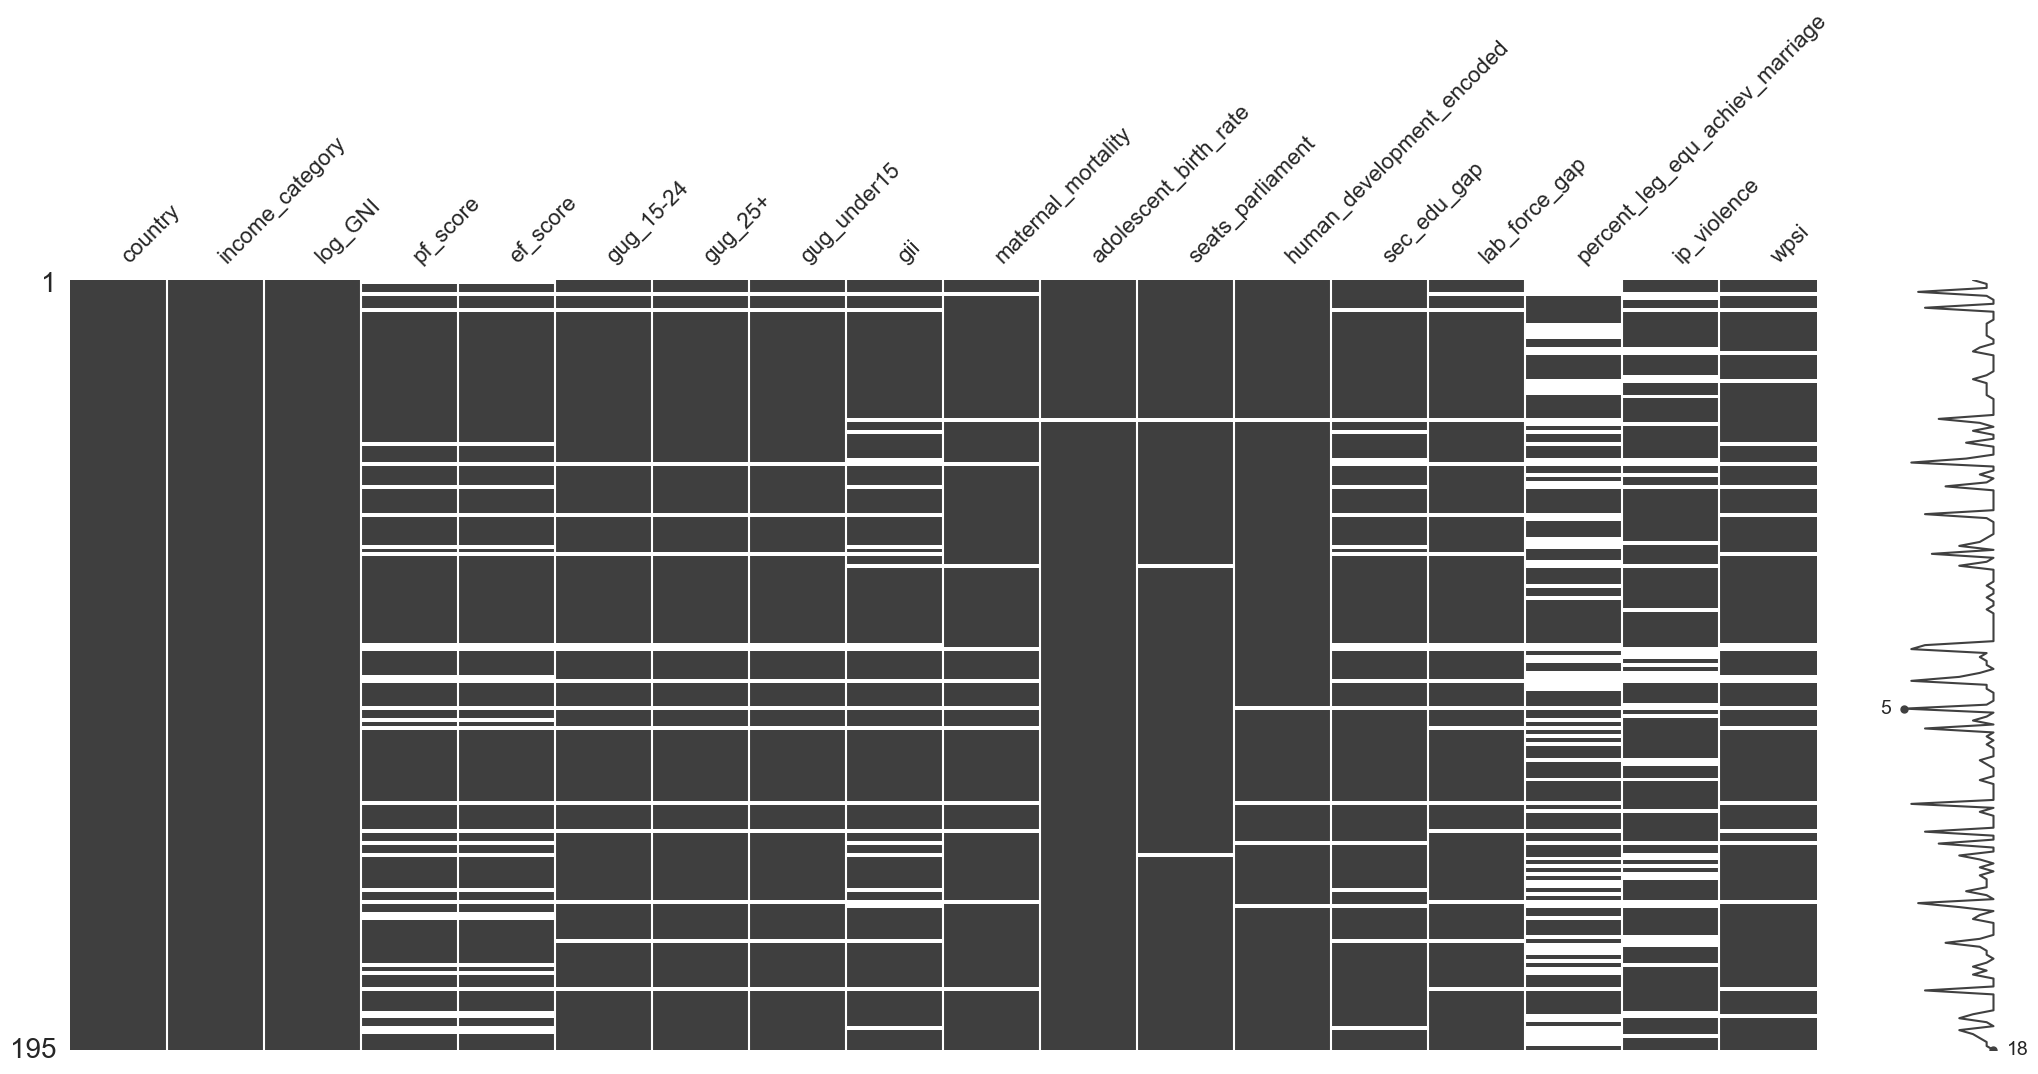

<Figure size 400x500 with 0 Axes>

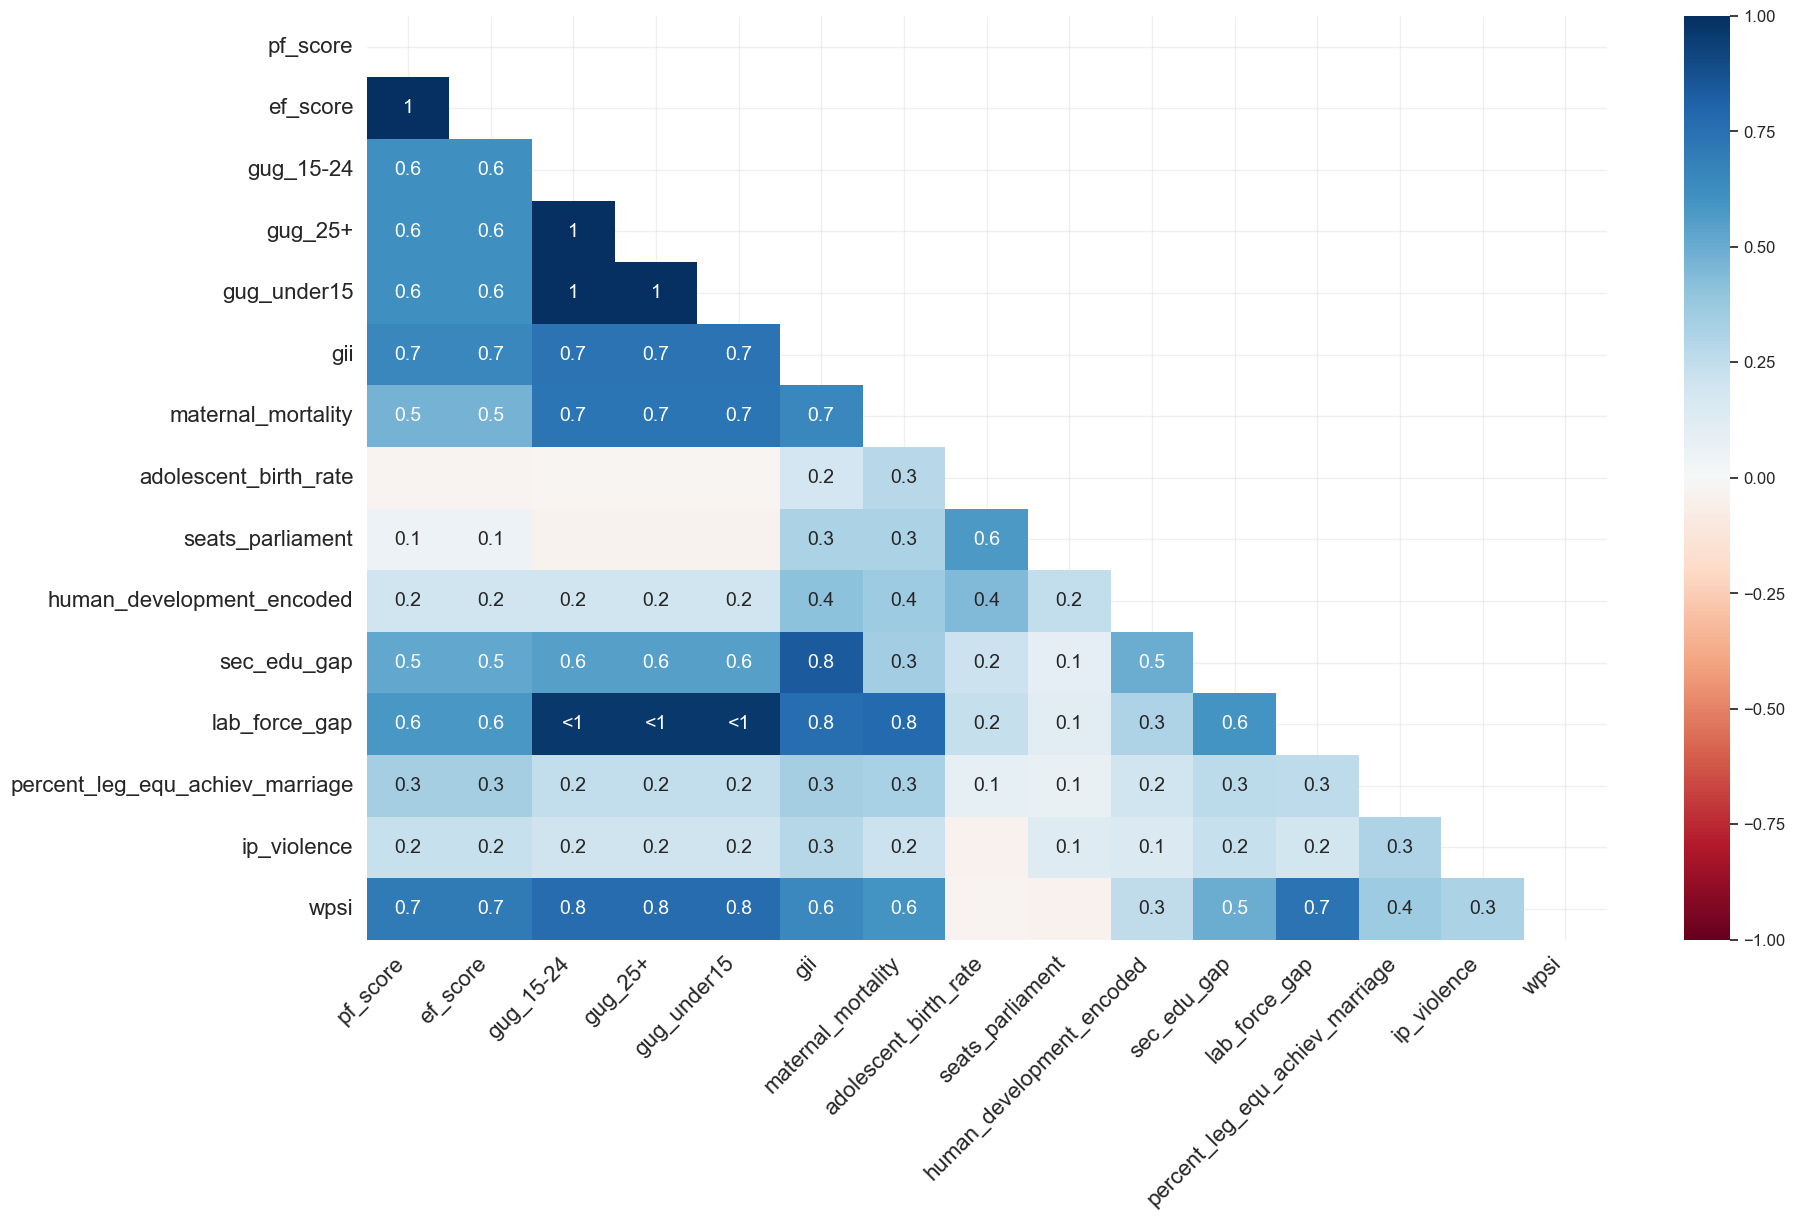

<Figure size 400x500 with 0 Axes>

                     country  income_category  log_GNI  pf_score  ef_score  gug_15-24  gug_25+  gug_under15   gii  \
income_category                                                                                                     
High Income             0.00             0.00     0.00     10.11     10.11       8.99     8.99         8.99 10.11   
Low Income              0.00             0.00     0.00     20.00     20.00       0.00     0.00         0.00 26.67   
Lower-Middle Income     0.00             0.00     0.00     16.67     16.67       6.67     6.67         6.67 16.67   
Upper-Middle Income     0.00             0.00     0.00     22.95     22.95       8.20     8.20         8.20 13.11   

                     maternal_mortality  adolescent_birth_rate  seats_parliament  human_development_encoded  \
income_category                                                                                               
High Income                        7.87                   0.00             

C:\Users\black\AppData\Local\Temp\ipykernel_36276\4186706311.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_income = global_df.groupby('income_category').apply(


In [ ]:
# Visualize missing data patterns
msno.matrix(global_df)
plt.show()

# Check if missingness is random or systematic
msno.heatmap(global_df)
plt.show()

# Analyze by income category
missing_by_income = global_df.groupby('income_category').apply(
    lambda x: x.isnull().sum() / len(x) * 100
)
print(missing_by_income)

#### 5.1 Handling Missing Data & Feature Engineeting

**!Missingness is NOT Random!**
Clear pattern:
- Low Income countries: Higher missingness in pf_score, ef_score, sec_edu_gap, percent_leg_equ_achiev_marriage (73%!), ip_violence (47%)
- High Income countries: More complete data, but still missing percent_leg_equ_achiev_marriage (27%), ip_violence (25%)
- *Selection Bias* poorer countries have less data infrastructure -> systematic underreporting --> need of sophisticated missing values data handling

In [181]:
def analyze_missing_patterns(df):
    """
    Analyze missing data patterns to inform imputation strategy
    """
    # Overall missingness
    missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    print("\nOverall Missing Data (%):")
    print(missing_pct[missing_pct > 0])
    
    # By income category
    missing_by_income = df.groupby('income_category').apply(
        lambda x: (x.isnull().sum() / len(x) * 100).round(2)
    )
    print(missing_by_income)
    
    return missing_pct


def create_missingness_flags(df):
    """
    Create binary flags for missing data (informative feature)
    """
    df_flagged = df.copy()
    
    # Flag high-missingness features
    high_miss_features = [
        'percent_leg_equ_achiev_marriage',
        'ip_violence',
        'wpsi',
        'sec_edu_gap'
    ]
    
    for feat in high_miss_features:
        if feat in df.columns:
            df_flagged[f'{feat}_missing'] = df[feat].isnull().astype(int)
    
    print("\n>>> Created missingness flags for high-missing features")
    return df_flagged


In [182]:
def handle_categorical_encoding(df):
    """
    Encode categorical variables before imputation
    """
    df_encoded = df.copy()
    
    # Income category: Ordinal encoding (natural order)
    income_order = {
        'Low Income': 0,
        'Lower-Middle Income': 1,
        'Upper-Middle Income': 2,
        'High Income': 3
    }
    df_encoded['income_category_encoded'] = df_encoded['income_category'].map(income_order)
    
    # Human development: Ordinal encoding
    if 'human_development_encoded' in df_encoded.columns:
        hd_order = {
            'low': 0,
            'medium': 1,
            'high': 2,
            'very high': 3
        }
        
        # Map values, NaN will remain NaN (will be imputed later)
        df_encoded['hd_encoded'] = df_encoded['human_development_encoded'].map(hd_order)
    else:
        # If column doesn't exist, create it as NaN (will be dropped or handled)
        df_encoded['hd_encoded'] = np.nan
    
    return df_encoded


def impute_missing_values(df, strategy='iterative'):
    """
    Impute missing values using multiple imputation
    """
    df_imputed = df.copy()
    
    # Define numeric columns to impute
    numeric_cols = [
        'log_GNI', 'pf_score', 'ef_score', 
        'gug_15-24', 'gug_25+', 'gug_under15',
        'gii', 'maternal_mortality', 'adolescent_birth_rate', 
        'seats_parliament', 'sec_edu_gap', 'lab_force_gap', 
        'wpsi', 'ip_violence',
        'income_category_encoded', 'hd_encoded'
    ]
    
    # Filter to existing columns and columns with at least some non-null values
    numeric_cols = [col for col in numeric_cols 
                    if col in df_imputed.columns 
                    and df_imputed[col].notna().sum() > 0]
    
    print(f"\n>>> Columns to impute: {len(numeric_cols)}")
    for col in numeric_cols:
        missing = df_imputed[col].isnull().sum()
        if missing > 0:
            print(f"    {col}: {missing} ({missing/len(df_imputed)*100:.1f}%)")
    
    if strategy == 'iterative':
        imputer = IterativeImputer(
            max_iter=10,
            random_state=42,
            min_value=0,  # Prevent negative values
            initial_strategy='median'
        )
        
        # Fit and transform
        imputed_data = imputer.fit_transform(df_imputed[numeric_cols])
        
        # Assign back to dataframe
        df_imputed[numeric_cols] = imputed_data
        
    elif strategy == 'income_stratified':
        for income_cat in df_imputed['income_category'].unique():
            mask = df_imputed['income_category'] == income_cat
            imputer = IterativeImputer(max_iter=10, random_state=42, min_value=0)
            
            imputed_data = imputer.fit_transform(df_imputed.loc[mask, numeric_cols])
            df_imputed.loc[mask, numeric_cols] = imputed_data
    
    elif strategy == 'simple':
        for col in numeric_cols:
            df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
    
    # Drop percent_leg_equ_achiev_marriage due to excessive missingness
    if 'percent_leg_equ_achiev_marriage' in df_imputed.columns:
        df_imputed = df_imputed.drop(columns=['percent_leg_equ_achiev_marriage'])
    
    remaining_nans = df_imputed[numeric_cols].isnull().sum().sum()
    print(f"\nRemaining NaNs: {remaining_nans}")
    
    # Final safety check - fill any remaining NaNs with median
    if remaining_nans > 0:
        print(f"Filling {remaining_nans} remaining NaNs with column medians")
        for col in numeric_cols:
            if df_imputed[col].isnull().any():
                df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
    
    return df_imputed

In [183]:
def engineer_composite_features(df):
    """
    Create composite indices to reduce dimensionality and multicollinearity
    """
    df_eng = df.copy()
    
    # Standardize for PCA and interactions
    numeric_cols = [
        'log_GNI', 'pf_score', 'ef_score', 
        'gug_15-24', 'gug_25+', 'gug_under15',
        'gii', 'maternal_mortality', 'adolescent_birth_rate',
        'seats_parliament', 'sec_edu_gap', 'lab_force_gap', 'wpsi',
        'income_category_encoded', 'hd_encoded'
    ]
    numeric_cols = [col for col in numeric_cols if col in df_eng.columns]
    
    # Check for and fill any remaining NaN values BEFORE scaling
    nan_found = False
    for col in numeric_cols:
        nan_count = df_eng[col].isnull().sum()
        if nan_count > 0:
            nan_found = True
            print(f"    WARNING: {col} has {nan_count} NaN values - filling with median")
            median_value = df_eng[col].median()
            if pd.isna(median_value):
                # If median is also NaN (all values are NaN), use 0
                print(f"    ERROR: {col} median is NaN - filling with 0")
                df_eng[col] = df_eng[col].fillna(0)
            else:
                df_eng[col] = df_eng[col].fillna(median_value)
    
    if not nan_found:
        print("No NaN values found")
    
    # Verify no NaNs remain
    total_nans = df_eng[numeric_cols].isnull().sum().sum()
    if total_nans > 0:
        print(f"\n    ERROR: Still have {total_nans} NaN values!")
        # Force fill everything with 0 as last resort
        df_eng[numeric_cols] = df_eng[numeric_cols].fillna(0)
        print("    Filled all remaining NaNs with 0")
    
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_eng[numeric_cols]),
        columns=numeric_cols,
        index=df_eng.index
    )
    
    # create composite feazures
    # ECONOMIC DEVELOPMENT INDEX
    economic_features = ['log_GNI', 'income_category_encoded', 'ef_score', 'hd_encoded']
    economic_features = [f for f in economic_features if f in df_scaled.columns]
    
    pca_econ = PCA(n_components=1)
    df_eng['economic_development_index'] = pca_econ.fit_transform(
        df_scaled[economic_features]
    )

    print(f"   Variance explained: {pca_econ.explained_variance_ratio_[0]:.3f}")
    print(f"   Components: {', '.join(economic_features)}")
    
    # GENDER INEQUALITY COMPOSITE
    gender_features = ['gii', 'sec_edu_gap', 'lab_force_gap', 'seats_parliament']
    gender_features = [f for f in gender_features if f in df_scaled.columns]
    
    pca_gender = PCA(n_components=1)
    df_eng['gender_inequality_composite'] = pca_gender.fit_transform(
        df_scaled[gender_features]
    )
    print(f"   Variance explained: {pca_gender.explained_variance_ratio_[0]:.3f}")
    print(f"   Components: {', '.join(gender_features)}")
    
    # YOUTH VULNERABILITY INDEX
    youth_features = ['gug_15-24', 'adolescent_birth_rate', 'gug_under15']
    youth_features = [f for f in youth_features if f in df_scaled.columns]
    
    df_eng['youth_vulnerability_index'] = df_scaled[youth_features].mean(axis=1)
    print(f"\n3. Youth Vulnerability Index")
    print(f"   Components: {', '.join(youth_features)}")
    
    # FREEDOM INDEX
    if 'pf_score' in df_scaled.columns and 'ef_score' in df_scaled.columns:
        df_eng['freedom_index'] = df_scaled[['pf_score', 'ef_score']].mean(axis=1)
        print(f"\n4. Freedom Index")
        print(f"   Components: pf_score, ef_score")
    
    # MATERNAL HEALTH INDEX
    if 'maternal_mortality' in df_scaled.columns and 'adolescent_birth_rate' in df_scaled.columns:
        df_eng['maternal_health_risk'] = (
            df_scaled['maternal_mortality'] + df_scaled['adolescent_birth_rate']
        ) / 2
        print(f"\n5. Maternal Health Risk Index")
        print(f"   Components: maternal_mortality, adolescent_birth_rate")
    
    return df_eng, df_scaled


def engineer_interaction_features(df, df_scaled):
    """
    Create domain-specific interaction features
    """
    df_int = df.copy()

    # Economic development × Gender inequality
    if 'economic_development_index' in df.columns and 'gender_inequality_composite' in df.columns:
        df_int['econ_gender_interaction'] = (
            df['economic_development_index'] * df['gender_inequality_composite']
        )
    
    # Freedom × Gender inequality
    if 'freedom_index' in df.columns and 'gender_inequality_composite' in df.columns:
        df_int['freedom_inequality_interaction'] = (
            df['freedom_index'] * df['gender_inequality_composite']
        )
    
    # ducation gap × Labor gap
    if 'sec_edu_gap' in df_scaled.columns and 'lab_force_gap' in df_scaled.columns:
        df_int['education_labor_alignment'] = (
            df_scaled['sec_edu_gap'] * df_scaled['lab_force_gap']
        )
    
    # 4. Youth unemployment × Adolescent births
    if 'gug_15-24' in df_scaled.columns and 'adolescent_birth_rate' in df_scaled.columns:
        df_int['youth_compound_risk'] = (
            df_scaled['gug_15-24'] * df_scaled['adolescent_birth_rate']
        )
    
    # 5. Political power × Economic power
    if 'seats_parliament' in df_scaled.columns and 'log_GNI' in df_scaled.columns:
        df_int['political_economic_empowerment'] = (
            df_scaled['seats_parliament'] * df_scaled['log_GNI']
        )
    
    return df_int


def engineer_ratio_features(df):
    """
    Create ratio features (relative measures)
    """
    df_ratio = df.copy()

    # 1. Political representation efficiency
    if 'seats_parliament' in df.columns and 'sec_edu_gap' in df.columns:
        df_ratio['political_education_efficiency'] = (
            df['seats_parliament'] / (100 - df['sec_edu_gap'] + 1)
        )
    
    # 2. Economic to personal freedom ratio
    if 'ef_score' in df.columns and 'pf_score' in df.columns:
        df_ratio['economic_to_personal_freedom'] = (
            df['ef_score'] / (df['pf_score'] + 1)
        )
    
    # 3. Youth to adult unemployment gap ratio
    if 'gug_15-24' in df.columns and 'gug_25+' in df.columns:
        df_ratio['youth_to_adult_gap_ratio'] = (
            df['gug_15-24'] / (df['gug_25+'] + 0.1)
        )
    
    return df_ratio

In [184]:
def create_categorical_features(df):
    """
    Create binned/categorical features for non-linear relationships
    """
    df_cat = df.copy()

    # 1. GII categories
    if 'gii' in df.columns:
        df_cat['gii_category'] = pd.qcut(
            df['gii'], 
            q=3, 
            labels=['low_inequality', 'medium_inequality', 'high_inequality']
        )
        df_cat = pd.get_dummies(df_cat, columns=['gii_category'], prefix='gii', drop_first=True)
   
    # 2. Parliamentary representation categories
    if 'seats_parliament' in df.columns:
        df_cat['parliament_category'] = pd.cut(
            df['seats_parliament'],
            bins=[0, 20, 35, 100],
            labels=['low_representation', 'medium_representation', 'high_representation']
        )
        df_cat = pd.get_dummies(df_cat, columns=['parliament_category'], prefix='parl', drop_first=True)
    
    # 3. Development level (already exists, just one-hot encode)
    if 'income_category' in df.columns:
        df_cat = pd.get_dummies(df_cat, columns=['income_category'], prefix='income', drop_first=True)
    
    return df_cat


def create_categorical_features(df):
    """
    Create binned/categorical features for non-linear relationships
    """
    df_cat = df.copy()
    # 1. GII categories
    if 'gii' in df.columns:
        df_cat['gii_category'] = pd.qcut(
            df['gii'], 
            q=3, 
            labels=['low_inequality', 'medium_inequality', 'high_inequality']
        )
        df_cat = pd.get_dummies(df_cat, columns=['gii_category'], prefix='gii', drop_first=True)

    # 2. Parliamentary representation categories
    if 'seats_parliament' in df.columns:
        df_cat['parliament_category'] = pd.cut(
            df['seats_parliament'],
            bins=[0, 20, 35, 100],
            labels=['low_representation', 'medium_representation', 'high_representation']
        )
        df_cat = pd.get_dummies(df_cat, columns=['parliament_category'], prefix='parl', drop_first=True)
        print("2. Parliamentary Representation Categories")
    
    # 3. Development level (already exists, just one-hot encode)
    if 'income_category' in df.columns:
        df_cat = pd.get_dummies(df_cat, columns=['income_category'], prefix='income', drop_first=True)
        print("3. Income Category Dummies")
    
    return df_cat


In [185]:
def select_final_features(df, target_var='ip_violence', feature_set='balanced'):
    """
    Select final feature set for modeling
    """
    df_final = df.copy()

    if feature_set == 'minimal':
        feature_cols = [
            'country',
            'economic_development_index',
            'gender_inequality_composite',
            'youth_vulnerability_index',
            'freedom_index',
            'maternal_health_risk',
            'wpsi',
            'ip_violence_missing'
        ]
    
    elif feature_set == 'balanced':
        feature_cols = [
            'country',
            'economic_development_index',
            'gender_inequality_composite',
            'youth_vulnerability_index',
            'freedom_index',
            'maternal_health_risk',
            'econ_gender_interaction',
            'freedom_inequality_interaction',
            'youth_compound_risk',
            'wpsi',
            'seats_parliament',
            'maternal_mortality',
            'ip_violence_missing',
            'wpsi_missing'
        ]
    
    elif feature_set == 'full':
        # Keep all engineered features
        exclude_cols = [
            'income_category', 'human_development_encoded',
            'pf_score', 'ef_score', 'gii',  
            'sec_edu_gap', 'lab_force_gap', 
            'income_category_encoded', 'hd_encoded'  
        ]
        feature_cols = [col for col in df_final.columns if col not in exclude_cols]
    
    # Filter to existing columns
    feature_cols = [col for col in feature_cols if col in df_final.columns]
    
    # Always include target if it exists
    if target_var in df_final.columns and target_var not in feature_cols:
        feature_cols.append(target_var)
    
    df_final = df_final[feature_cols]
    
    print(f"\nFinal dataset shape: {df_final.shape}")
    print(f"Features selected: {len(feature_cols) - 1}")  
    print("\nColumns:")
    for col in df_final.columns:
        print(f"  - {col}")
    
    return df_final


def full_pipeline(df, imputation_strategy='iterative', feature_set='balanced', 
                  target_var='ip_violence'):
    """
    Complete feature engineering pipeline for global VAWG dataset
    """
    missing_pct = analyze_missing_patterns(df)
    df = create_missingness_flags(df)
    df = handle_categorical_encoding(df)
    df = impute_missing_values(df, strategy=imputation_strategy)
    df, df_scaled = engineer_composite_features(df)
    df = engineer_interaction_features(df, df_scaled)
    df = engineer_ratio_features(df)
    df = create_categorical_features(df)
    df_final = select_final_features(df, target_var=target_var, feature_set=feature_set)

    return df_final

In [187]:
# Balanced feature set with iterative imputation
global_df_final = full_pipeline(
    df=global_df,
    imputation_strategy='iterative',
    feature_set='balanced',
    target_var='ip_violence'
    )


Overall Missing Data (%):
percent_leg_equ_achiev_marriage   38.97
ip_violence                       23.08
pf_score                          15.90
ef_score                          15.90
gii                               13.33
wpsi                              10.77
sec_edu_gap                        9.74
lab_force_gap                      8.21
gug_15-24                          7.69
gug_under15                        7.69
gug_25+                            7.69
maternal_mortality                 6.15
human_development_encoded          2.56
seats_parliament                   1.54
adolescent_birth_rate              0.51
dtype: float64
                     country  income_category  log_GNI  pf_score  ef_score  gug_15-24  gug_25+  gug_under15   gii  \
income_category                                                                                                     
High Income             0.00             0.00     0.00     10.11     10.11       8.99     8.99         8.99 10.11   
Low Inc

In [188]:
global_df_final

,country,economic_development_index,gender_inequality_composite,youth_vulnerability_index,freedom_index,maternal_health_risk,econ_gender_interaction,freedom_inequality_interaction,youth_compound_risk,wpsi,seats_parliament,maternal_mortality,ip_violence_missing,wpsi_missing,ip_violence
0,Afghanistan,-3.44,2.01,1.94,-2.28,1.56,-6.91,-4.60,1.46,0.29,27.20,638.00,0,0,46.00
1,Angola,-0.96,1.25,0.32,-0.73,1.42,-1.20,-0.92,-2.58,0.60,29.50,241.00,0,0,38.00
2,Albania,1.15,-1.69,-0.72,0.82,-0.70,-1.94,-1.39,0.62,0.80,35.70,15.00,0,0,13.00
3,Andorra,1.66,-2.13,-0.53,0.83,-0.85,-3.54,-1.76,0.29,0.85,46.40,0.00,1,1,20.16
4,United Arab Emirates,1.70,-1.68,0.25,-0.35,-0.88,-2.85,0.59,-1.31,0.87,50.00,3.00,1,0,20.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Samoa,-0.91,0.36,1.15,-0.63,-0.26,-0.33,-0.23,-0.05,0.71,7.80,43.00,0,0,40.00
199,Yemen,-3.10,4.33,1.15,-1.97,0.15,-13.41,-8.51,0.11,0.29,0.30,164.00,1,0,29.48
200,South Africa,-0.17,-0.01,0.57,0.03,0.14,0.00,-0.00,0.34,0.69,46.00,119.00,0,0,24.00
201,Zambia,-1.50,1.15,0.45,-0.28,1.07,-1.73,-0.32,-0.66,0.56,15.10,213.00,0,0,41.00


In [189]:
global_df_final.to_csv(FEATENG_DIR / "global_df_final", index=False)